This notebook uses the three raw data coordinate estimation models (one each for m/z, RT, and scan) to estimate where in the raw data a sequence should be (based on where it was found on average in other runs) and extracts metrics of the feature found at those coordinates.

In [1]:
import pandas as pd
import numpy as np
import sys
import pickle
import glob
import os
import sqlite3
import peakutils
from scipy import signal
import matplotlib.pyplot as plt

In [2]:
PROTON_MASS = 1.007276
MS1_COLLISION_ENERGY = 10

In [3]:
def calculate_monoisotopic_mass_from_mz(monoisotopic_mz, charge):
    monoisotopic_mass = (monoisotopic_mz * charge) - (PROTON_MASS * charge)
    return monoisotopic_mass

In [4]:
# calculate the r-squared value of series_2 against series_1, where series_1 is the original data (source: https://stackoverflow.com/a/37899817/1184799)
def calculate_r_squared(series_1, series_2):
    residuals = series_1 - series_2
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((series_1 - np.mean(series_1))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

In [5]:
# get the ms1 frame ids with a range of RT as a tuple
def get_ms1_frame_ids(converted_db_name, rt_lower, rt_upper):
    db_conn = sqlite3.connect(converted_db_name)
    ms1_frame_properties_df = pd.read_sql_query("select frame_id,retention_time_secs from frame_properties where retention_time_secs >= {} and retention_time_secs <= {} and collision_energy == {} order by retention_time_secs".format(rt_lower, rt_upper, MS1_COLLISION_ENERGY), db_conn)
    db_conn.close()
    ms1_frame_ids = tuple(ms1_frame_properties_df.frame_id)
    return ms1_frame_ids

In [6]:
FILE_IDX_FOR_ANALYSIS = 0

In [7]:
SEQUENCE_FILE_COUNTS_FILE_NAME = '/Users/darylwilding-mcbride/Downloads/sequence-charge-file-counts-df.pkl'

In [8]:
sequence_file_counts_df = pd.read_pickle(SEQUENCE_FILE_COUNTS_FILE_NAME)

In [9]:
sequence_file_counts_df[sequence_file_counts_df.file_idxs.apply(lambda x: 0 not in x)].sample(n=20)  # use 'not in x' for sequences missed in this file

,sequence,charge,number_of_files,file_idxs
27116,TYTVNTLQTLTSQLLK,2,7,"[1, 2, 11, 13, 14, 15, 17]"
25503,TEGVGPGVPGEVEMVK,2,1,[11]
25739,TGLWVGDCFIYTSSVNR,2,2,"[13, 15]"
19372,NCTYTQVQTR,2,2,"[13, 15]"
9209,GAMELEPELLLQEAR,2,1,[11]
2180,ASMDVENPDYSEEILK,2,1,[1]
17664,LSTSGNRPPANAETFSCNK,3,1,[10]
20735,QASVGAGIPYSVPAWSCQMICGSGLK,3,2,"[14, 18]"
20972,QFVVFEGNHYFYSPYPTK,3,1,[18]
21526,QSDHQFLHQSNVFHHINNILSK,4,1,[10]


In [10]:
SEQUENCE_ROW_IDX_FOR_ANALYSIS = 21010

In [11]:
EXPERIMENT_SEQUENCE_ATTRIBS_FILE_NAME = '/Users/darylwilding-mcbride/Downloads/experiments/190719_Hela_Ecoli/training-sets/experiment-sequence-charge-attribs-df.pkl'

In [12]:
experiment_sequence_attribs_df = pd.read_pickle(EXPERIMENT_SEQUENCE_ATTRIBS_FILE_NAME)

In [13]:
experiment_sequence_attribs_df.head()

,sequence,charge,theoretical_mz,experiment_scan_mean,experiment_scan_std_dev,experiment_scan_peak_width,experiment_rt_mean,experiment_rt_std_dev,experiment_rt_peak_width,experiment_intensity_mean,experiment_intensity_std_dev,number_of_runs_identified
0,AAAAAAAAAPAAAATAPTTAATTAATAAQ,2,1184.608726,73.528889,1.531219,57.626667,604.371111,5.384613,18.706667,108754.444444,50668.321607,7
1,AAAAAAAAAPAAAATAPTTAATTAATAAQ,3,790.074909,336.016667,1.172187,56.366667,609.890000,0.369143,5.030000,29377.333333,5956.040202,3
2,AAAAAAAAVPSAGPAGPAPTSAAGR,2,1016.532126,159.998000,4.066732,64.555556,489.613333,3.195292,6.357111,58456.622222,10825.860309,20
3,AAAAALSQQQSLQER,2,786.410426,496.325000,0.920801,45.912500,375.042500,0.206927,6.140000,57092.250000,3215.380411,3
4,AAAAATVVPPMVGGPPFVGPVGFGPGDR,3,864.452776,706.957407,4.393825,48.382593,1039.716667,4.004130,16.666296,50988.518519,14686.950392,13


In [14]:
# use the run-0 model to find AAAAATVVPPMVGGPPFVGPVGFGPGDR, charge 3 in the raw data of the file idx
RUN_MZ_MODEL_FILE_NAME = '/Users/darylwilding-mcbride/Downloads/experiments/190719_Hela_Ecoli/trained-models/file-{}-mz-model.pkl'.format(FILE_IDX_FOR_ANALYSIS)
RUN_SCAN_MODEL_FILE_NAME = '/Users/darylwilding-mcbride/Downloads/experiments/190719_Hela_Ecoli/trained-models/file-{}-scan-model.pkl'.format(FILE_IDX_FOR_ANALYSIS)
RUN_RT_MODEL_FILE_NAME = '/Users/darylwilding-mcbride/Downloads/experiments/190719_Hela_Ecoli/trained-models/file-{}-rt-model.pkl'.format(FILE_IDX_FOR_ANALYSIS)

In [15]:
with open(RUN_MZ_MODEL_FILE_NAME, 'rb') as file:
    mz_estimator = pickle.load(file)
with open(RUN_SCAN_MODEL_FILE_NAME, 'rb') as file:
    scan_estimator = pickle.load(file)
with open(RUN_RT_MODEL_FILE_NAME, 'rb') as file:
    rt_estimator = pickle.load(file)

In [16]:
# gather the sequence attributes to plug into each model
sequence_df = pd.DataFrame(experiment_sequence_attribs_df.iloc[SEQUENCE_ROW_IDX_FOR_ANALYSIS]).transpose()

In [17]:
sequence_df

,sequence,charge,theoretical_mz,experiment_scan_mean,experiment_scan_std_dev,experiment_scan_peak_width,experiment_rt_mean,experiment_rt_std_dev,experiment_rt_peak_width,experiment_intensity_mean,experiment_intensity_std_dev,number_of_runs_identified
21010,QGPQIVVGTPGR,2,604.841,737.63,0.54,91.87,478.365,0.695,15.7,285812,34168.5,2


In [18]:
sequence_estimation_attribs_df = sequence_df[['theoretical_mz','experiment_rt_mean','experiment_rt_std_dev','experiment_scan_mean','experiment_scan_std_dev','experiment_intensity_mean','experiment_intensity_std_dev']]
sequence_estimation_attribs = sequence_estimation_attribs_df.values

In [19]:
sequence_estimation_attribs

array([[604.8409260000001, 478.365, 0.6949999999999932, 737.63,
        0.5399999999999636, 285812.5, 34168.5]], dtype=object)

In [20]:
# estimate the raw monoisotopic m/z
mz_delta_ppm_estimated = mz_estimator.predict(sequence_estimation_attribs)[0]
theoretical_mz = sequence_estimation_attribs_df.iloc[0].theoretical_mz
estimated_monoisotopic_mz = (mz_delta_ppm_estimated / 1e6 * theoretical_mz) + theoretical_mz
estimated_monoisotopic_mz

604.8411811752987

In [21]:
# estimate the raw monoisotopic scan
estimated_scan_delta = scan_estimator.predict(sequence_estimation_attribs)[0]
experiment_scan_mean = sequence_estimation_attribs_df.iloc[0].experiment_scan_mean
estimated_scan_apex = (estimated_scan_delta * experiment_scan_mean) + experiment_scan_mean
estimated_scan_apex

737.9889841471154

In [22]:
# estimate the raw monoisotopic RT
estimated_rt_delta = rt_estimator.predict(sequence_estimation_attribs)[0]
experiment_rt_mean = sequence_estimation_attribs_df.iloc[0].experiment_rt_mean
estimated_rt_apex = (estimated_rt_delta * experiment_rt_mean) + experiment_rt_mean
estimated_rt_apex

473.19798394176235

Look in the raw data for a feature at these coordinates

In [23]:
# the width to use for isotopic width, in Da
MZ_TOLERANCE_PPM = 5  # +/- this amount
MZ_TOLERANCE_PERCENT = MZ_TOLERANCE_PPM * 10**-4
MS1_PEAK_DELTA = estimated_monoisotopic_mz * MZ_TOLERANCE_PERCENT / 100

In [24]:
MS1_PEAK_DELTA

0.0030242059058764935

In [25]:
# Mass difference between Carbon-12 and Carbon-13 isotopes, in Da. For calculating the spacing between isotopic peaks.
CARBON_MASS_DIFFERENCE = 1.003355

# the collision energy to distinguish ms1 and ms2 frames
MS1_COLLISION_ENERGY = 10

In [26]:
# takes a numpy array of intensity, and another of mz
def mz_centroid(_int_f, _mz_f):
    return ((_int_f/_int_f.sum()) * _mz_f).sum()

In [27]:
NUMBER_OF_ISOTOPES = 7     # the number of isotopes to look for in the m/z dimension - the theoretical model includes 7 (the monoisotopic plus 6 isotopes)

expected_spacing_mz = CARBON_MASS_DIFFERENCE / sequence_df.iloc[0].charge

In [28]:
# distance for looking either side of the scan and RT apex, based on the other times this sequence has been seen in this experiment
RT_WIDTH = sequence_df.iloc[0].experiment_rt_peak_width
SCAN_WIDTH = sequence_df.iloc[0].experiment_scan_peak_width

In [29]:
feature_region_mz_lower = estimated_monoisotopic_mz - MS1_PEAK_DELTA
feature_region_mz_upper = estimated_monoisotopic_mz + (NUMBER_OF_ISOTOPES * expected_spacing_mz) + MS1_PEAK_DELTA
scan_lower = estimated_scan_apex - (2 * SCAN_WIDTH)
scan_upper = estimated_scan_apex + (2 * SCAN_WIDTH)
rt_lower = estimated_rt_apex - (2 * RT_WIDTH)
rt_upper = estimated_rt_apex + (2 * RT_WIDTH)
print("mz: {}-{}, scan: {}-{}, rt: {}-{}".format(round(feature_region_mz_lower,4), round(feature_region_mz_upper,4), int(scan_lower), int(scan_upper), round(rt_lower,1), round(rt_upper,1)))

mz: 604.8382-608.3559, scan: 554-921, rt: 441.8-504.6


In [30]:
# find the converted database file name for file idx 0
MAPPING_FILE_NAME = '/Users/darylwilding-mcbride/Downloads/percolator_mapping_df.pkl'
mapping_df = pd.read_pickle(MAPPING_FILE_NAME)

In [31]:
run_name = mapping_df[mapping_df.file_idx == FILE_IDX_FOR_ANALYSIS].iloc[0].run_name
run_name

'190719_Hela_Ecoli_1to3_06-recalibrated'

In [32]:
db_name = run_name.replace('-recalibrated', '-converted.sqlite')

In [33]:
CONVERTED_DATABASE_NAME = '/Users/darylwilding-mcbride/Downloads/experiments/190719_Hela_Ecoli/converted-databases/{}'.format(db_name)
CONVERTED_DATABASE_NAME

'/Users/darylwilding-mcbride/Downloads/experiments/190719_Hela_Ecoli/converted-databases/190719_Hela_Ecoli_1to3_06-converted.sqlite'

In [34]:
# get the ms1 frame ids within a defined RT range
ms1_frame_ids = get_ms1_frame_ids(CONVERTED_DATABASE_NAME, rt_lower, rt_upper)

In [35]:
# extract the raw data within this area of interest
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
feature_region_raw_points_df = pd.read_sql_query("select frame_id,mz,scan,intensity,retention_time_secs from frames where mz >= {} and mz <= {} and scan >= {} and scan <= {} and retention_time_secs >= {} and retention_time_secs <= {} and frame_id in {}".format(feature_region_mz_lower, feature_region_mz_upper, scan_lower, scan_upper, rt_lower, rt_upper, ms1_frame_ids), db_conn)
db_conn.close()

In [36]:
sequence_name = sequence_df.iloc[0].sequence
sequence_charge = sequence_df.iloc[0].charge

In [37]:
# take a wider view for visualisation of the context
feature_region_mz_wide_lower = feature_region_mz_lower - 1
feature_region_mz_wide_upper = feature_region_mz_upper + 1
scan_wide_lower = scan_lower - 30
scan_wide_upper = scan_upper + 30
rt_wide_lower = estimated_rt_apex - 1
rt_wide_upper = estimated_rt_apex + 1

# extract the raw data within this area of interest
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
wide_feature_region_raw_points_df = pd.read_sql_query("select frame_id,mz,scan,intensity,retention_time_secs from frames where mz >= {} and mz <= {} and scan >= {} and scan <= {} and retention_time_secs >= {} and retention_time_secs <= {} and frame_id in {}".format(feature_region_mz_wide_lower, feature_region_mz_wide_upper, scan_wide_lower, scan_wide_upper, rt_wide_lower, rt_wide_upper, ms1_frame_ids), db_conn)
db_conn.close()

In [38]:
isotope_peaks_l = []
isotope_raw_points_l = []
# derive peaks for the monoisotopic and the isotopes
mz = estimated_monoisotopic_mz
for isotope_idx in range(NUMBER_OF_ISOTOPES):
    estimated_isotope_midpoint = mz + (isotope_idx * expected_spacing_mz)
    isotope_mz_lower = estimated_isotope_midpoint - MS1_PEAK_DELTA
    isotope_mz_upper = estimated_isotope_midpoint + MS1_PEAK_DELTA
    isotope_raw_points_df = feature_region_raw_points_df[(feature_region_raw_points_df.mz >= isotope_mz_lower) & (feature_region_raw_points_df.mz <= isotope_mz_upper)]
    # add the isotope's raw points to the list
    isotope_raw_points_l.append(isotope_raw_points_df)
    # centroid the raw points to get the peak for the isotope
    isotope_raw_points_a = isotope_raw_points_df[['mz','intensity']].values
    mz_cent = mz_centroid(isotope_raw_points_a[:,1], isotope_raw_points_a[:,0])
    summed_intensity = isotope_raw_points_a[:,1].sum()
    # add the peak to the list of isotopic peaks
    isotope_peaks_l.append((mz_cent, summed_intensity))
    if isotope_idx == 0:
        # set the m/z reference point to be the monoisotope's centroided m/z
        mz = mz_cent
isotope_peaks_df = pd.DataFrame(isotope_peaks_l, columns=['mz_centroid','summed_intensity'])

In [39]:
estimated_monoisotopic_mz

604.8411811752987

In [40]:
isotope_peaks_df

,mz_centroid,summed_intensity
0,604.841662,44860.0
1,605.343166,39693.0
2,605.845010,46699.0
3,606.347270,59214.0
4,606.848726,73802.0
5,607.349273,22603.0
6,607.851778,10495.0


In [41]:
len(isotope_raw_points_l)

7

In [42]:
# assumes the isotope's raw points have already been flattened to a particular dimension (e.g. scan, RT, m/z) and 
# sorted by ascending order in that dimension
def fit_curve_to_flattened_isotope(flattened_points_df, estimated_apex, estimated_peak_width):
    results_d = {}
    curve_fit = False
    # apply a filter to make curve fitting easier
    window_length = 11
    if len(flattened_points_df) > window_length:
        flattened_points_df['filtered_intensity'] = signal.savgol_filter(flattened_points_df.intensity, window_length=window_length, polyorder=3)
    else:
        print("there are fewer points ({}) than the window length ({})".format(len(flattened_points_df), window_length))
        flattened_points_df['filtered_intensity'] = flattened_points_df.intensity
    # determine whether there's more than one peak
    peak_maxima_indexes = peakutils.indexes(flattened_points_df.filtered_intensity.values, thres=0.05, min_dist=estimated_peak_width/4, thres_abs=False)
    print("there are {} peaks".format(len(peak_maxima_indexes)))
    results_d["number_of_peaks"] = len(peak_maxima_indexes)
    results_d["original_intensity_filtered"] = flattened_points_df.filtered_intensity.values
    
    if len(peak_maxima_indexes) > 0:
        # if there's more than one peak, we need to trim the data to a single peak
        if len(peak_maxima_indexes) > 1:
            peaks_df = flattened_points_df.iloc[peak_maxima_indexes].copy()
            # find the peak closest to the estimated apex
            peaks_df['apex_delta'] = abs(peaks_df.x - estimated_apex)
            peak_idx = peaks_df.apex_delta.idxmin()

            valleys_idx = peakutils.indexes(-flattened_points_df.filtered_intensity.values, thres=0.5, min_dist=estimated_peak_width/4, thres_abs=False)
            valleys_df = flattened_points_df.iloc[valleys_idx].copy()
            # find the closest valley above the peak
            if max(valleys_idx) > peak_idx:
                valley_idx_above = valleys_idx[valleys_idx > peak_idx].min()
                base_upper = valleys_df.loc[valley_idx_above].x
                flattened_points_df = flattened_points_df[(flattened_points_df.x <= base_upper)]
            else:
                print("could not find a valley above the peak")
                valley_idx_above = -1
            # find the closest valley below the peak
            if min(valleys_idx) < peak_idx:
                valley_idx_below = valleys_idx[valleys_idx < peak_idx].max()
                base_lower = valleys_df.loc[valley_idx_below].x
                flattened_points_df = flattened_points_df[(flattened_points_df.x >= base_lower)]
            else:
                print("could not find a valley below the peak")
                valley_idx_below = -1

            results_d["peaks_df"] = peaks_df
            results_d["selected_peak_idx"] = peak_idx
            results_d["peak_maxima_indexes"] = peak_maxima_indexes
            results_d["valleys_df"] = valleys_df
            results_d["valley_idx_below"] = valley_idx_below
            results_d["valley_idx_above"] = valley_idx_above

        # fit to the top most interesting bit of the curve
        flattened_points_df = flattened_points_df[flattened_points_df.filtered_intensity >= (flattened_points_df.filtered_intensity.max() * 0.02)]
        
        # fit a gaussian curve to the data
        gaussian_params = peakutils.peak.gaussian_fit(flattened_points_df.x.values, flattened_points_df.filtered_intensity.values, center_only=False)
        curve_fit = True
        apex_x = gaussian_params[1]
        std_dev = abs(gaussian_params[2])
        fitted_intensity_values = peakutils.peak.gaussian(flattened_points_df.x.values, gaussian_params[0], gaussian_params[1], gaussian_params[2])
        fitted_curve_df = flattened_points_df.copy()
        fitted_curve_df['fitted_intensity'] = fitted_intensity_values
        area_under_curve = fitted_intensity_values.sum()
        intensity_at_apex = peakutils.peak.gaussian(apex_x, gaussian_params[0], gaussian_params[1], gaussian_params[2])

        # calculate the r-squared value of the fitted curve
        r_squared = calculate_r_squared(series_1=flattened_points_df.intensity, series_2=fitted_intensity_values)

        # calculate the peak symmetry
        lhs_auc = flattened_points_df[(flattened_points_df.x <= apex_x)].intensity.sum()
        rhs_auc = flattened_points_df[(flattened_points_df.x > apex_x)].intensity.sum()
        if rhs_auc == 0:
            peak_symmetry = 0
        else:
            peak_symmetry = lhs_auc / rhs_auc
    else:
        std_dev = np.std(flattened_points_df.x)
        r_squared = 0
        apex_x = flattened_points_df.iloc[flattened_points_df.intensity.idxmax()].x
        intensity_at_apex = flattened_points_df.intensity.max()
        area_under_curve = flattened_points_df.x.sum()
        peak_symmetry = 0
        fitted_curve_df = pd.DataFrame()

    # collate the metrics into the results dictionary
    results_d["std_dev"] = std_dev
    results_d["full_width_half_max"] = 2.355 * std_dev  # https://ned.ipac.caltech.edu/level5/Leo/Stats2_3.html
    results_d["base_width"] = 6 * std_dev  # https://ned.ipac.caltech.edu/level5/Leo/Stats2_3.html
    results_d["base_lower"] = apex_x - (3 * std_dev)  # https://ned.ipac.caltech.edu/level5/Leo/Stats2_3.html
    results_d["base_upper"] = apex_x + (3 * std_dev)  # https://ned.ipac.caltech.edu/level5/Leo/Stats2_3.html
    results_d["r_squared"] = r_squared
    results_d["apex"] = apex_x
    results_d["intensity_at_apex"] = intensity_at_apex
    results_d["fitted"] = curve_fit
    results_d["area_under_curve"] = area_under_curve
    results_d["peak_symmetry"] = peak_symmetry
    results_d["fitted_curve_df"] = fitted_curve_df
    results_d["isolated_peak_df"] = flattened_points_df

    return results_d

In [43]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
# Rescale to values between 0 and 1 
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)

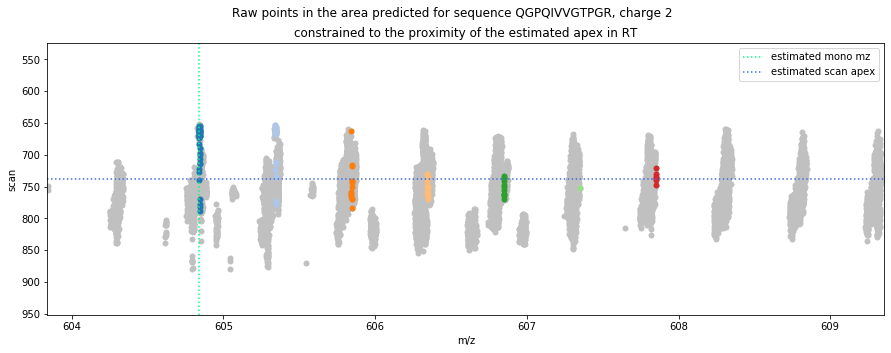

In [44]:
f, ax = plt.subplots()
ax.plot(wide_feature_region_raw_points_df.mz, wide_feature_region_raw_points_df.scan, marker='o', color='silver', linestyle='', ms=5)
for idx,isotope_raw_df in enumerate(isotope_raw_points_l):
    visualise_df = isotope_raw_df[(isotope_raw_df.retention_time_secs >= rt_wide_lower) & (isotope_raw_df.retention_time_secs <= rt_wide_upper)]
    ax.plot(visualise_df.mz, visualise_df.scan, marker='o', color=tableau20[idx], linestyle='', ms=5)
plt.axvline(x=estimated_monoisotopic_mz, linestyle=':', color='springgreen', label='estimated mono mz')
plt.axhline(y=estimated_scan_apex, linestyle=':', color='royalblue', label='estimated scan apex')
plt.xlabel('m/z')
plt.ylabel('scan')
plt.legend(loc='best')
plt.gca().invert_yaxis()
f.set_figheight(5)
f.set_figwidth(15)
plt.suptitle('Raw points in the area predicted for sequence {}, charge {}'.format(sequence_name, sequence_charge))
plt.title('constrained to the proximity of the estimated apex in RT')
plt.xlim((feature_region_mz_wide_lower,feature_region_mz_wide_upper))
plt.ylim((scan_wide_upper,scan_wide_lower))
plt.margins(0.06)
plt.show()

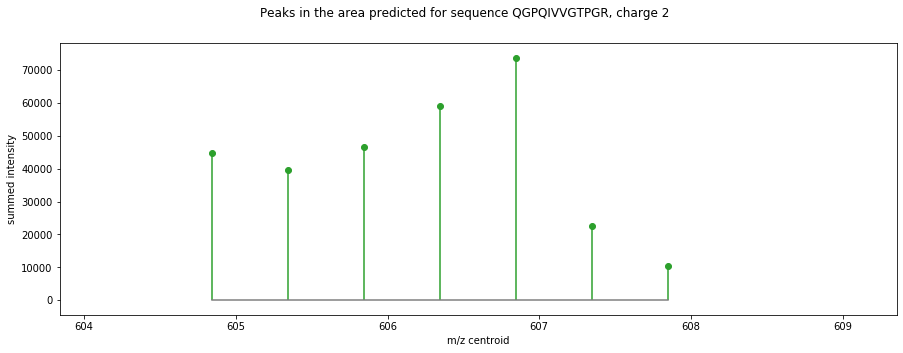

In [45]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
markerline, stemlines, baseline = ax.stem(isotope_peaks_df.mz_centroid, isotope_peaks_df.summed_intensity, 'g', use_line_collection=True)
plt.setp(markerline, 'color', colors[2])
plt.setp(stemlines, 'color', colors[2])
plt.setp(baseline, 'color', colors[7])
plt.xlabel('m/z centroid')
plt.ylabel('summed intensity')
plt.xlim((feature_region_mz_wide_lower,feature_region_mz_wide_upper))
f.set_figheight(5)
f.set_figwidth(15)
plt.margins(0.06)
plt.suptitle('Peaks in the area predicted for sequence {}, charge {}'.format(sequence_name, sequence_charge))
plt.show()

#### Monoisotopic peak
We have confidence in the accuracy of each dimension in decreasing order: m/z, RT, scan. Therefore we constrain the cuboid by m/z first to find the peak in RT, then constrain the points to the RT peak's FWHM, then find the peak in the scan dimension.

In [91]:
mono_raw_points_df = isotope_raw_points_l[0]

Collapse the points onto the RT dimension

In [92]:
rt_0_df = mono_raw_points_df.groupby(['frame_id','retention_time_secs'], as_index=False).intensity.sum()
rt_0_df.sort_values(by=['retention_time_secs'], ascending=True, inplace=True)
rt_0_df['x'] = rt_0_df.retention_time_secs
rt_0_metrics = fit_curve_to_flattened_isotope(rt_0_df, estimated_rt_apex, RT_WIDTH)

there are 7 peaks


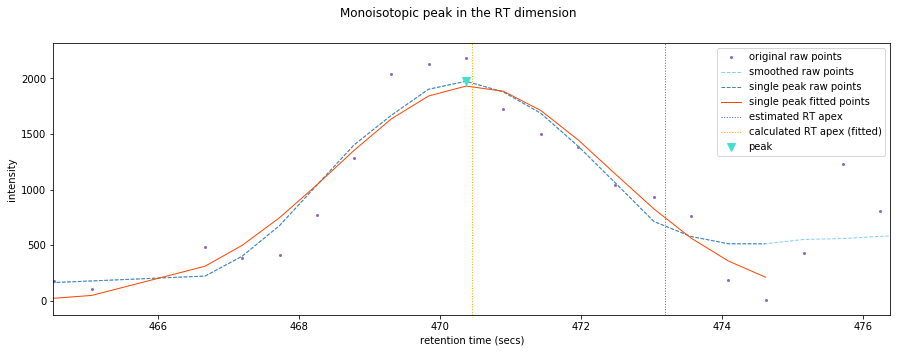

In [48]:
f, ax = plt.subplots()
# plot the original raw data
ax.plot(rt_0_df.retention_time_secs, rt_0_df.intensity, marker='o', color='tab:purple', linestyle='', linewidth=2, ms=2, label='original raw points')
# plot the filtered intensity values
ax.plot(rt_0_df.retention_time_secs, rt_0_metrics['original_intensity_filtered'], marker='', color='lightskyblue', linestyle='--', linewidth=1, ms=5, label='smoothed raw points')
if rt_0_metrics['number_of_peaks'] > 0:
    # plot the original filtered data constrained to a single peak
    ax.plot(rt_0_metrics['fitted_curve_df'].retention_time_secs, rt_0_metrics['fitted_curve_df'].filtered_intensity, marker='', color='steelblue', linestyle='--', linewidth=1, ms=5, label='single peak raw points')
    # plot the fitted curve
    ax.plot(rt_0_metrics['fitted_curve_df'].retention_time_secs, rt_0_metrics['fitted_curve_df'].fitted_intensity, marker='', color='orangered', linestyle='-', linewidth=1, ms=5, label='single peak fitted points')
# show the estimated apex
plt.axvline(x=estimated_rt_apex, linestyle=':', color='royalblue', linewidth=1, label='estimated RT apex')
# show the calculated apex
plt.axvline(x=rt_0_metrics['apex'], linestyle=':', color='orange', linewidth=1, label='calculated RT apex (fitted)')
# show the peaks if there's more than one
if rt_0_metrics['number_of_peaks'] > 1:
    peak_idxs = rt_0_metrics['peak_maxima_indexes']
    ax.plot(rt_0_df.retention_time_secs.iloc[peak_idxs], rt_0_metrics['original_intensity_filtered'][peak_idxs], marker='v', color='turquoise', linestyle='', markeredgewidth=1, ms=8, label='peak')
plt.xlabel('retention time (secs)')
plt.ylabel('intensity')
plt.legend(loc='best')
f.set_figheight(5)
f.set_figwidth(15)
plt.xlim((rt_0_metrics['base_lower'],rt_0_metrics['base_upper']))
plt.suptitle('Monoisotopic peak in the RT dimension')
plt.margins(0.06)
plt.show()

Collapse the points onto the mobility dimension, constraining the points to the FWHM of the peak in RT

In [49]:
rt_peak_fwhm_lower = rt_0_metrics['apex'] - (rt_0_metrics['full_width_half_max'])
rt_peak_fwhm_upper = rt_0_metrics['apex'] + (rt_0_metrics['full_width_half_max'])
mono_raw_points_df = mono_raw_points_df[(mono_raw_points_df.retention_time_secs >= rt_peak_fwhm_lower) & (mono_raw_points_df.retention_time_secs <= rt_peak_fwhm_upper)].copy()

In [50]:
scan_0_df = mono_raw_points_df.groupby(['scan'], as_index=False).intensity.sum()
scan_0_df.sort_values(by=['scan'], ascending=True, inplace=True)
scan_0_df['x'] = scan_0_df.scan
scan_0_metrics = fit_curve_to_flattened_isotope(scan_0_df, estimated_scan_apex, SCAN_WIDTH)

there are 3 peaks


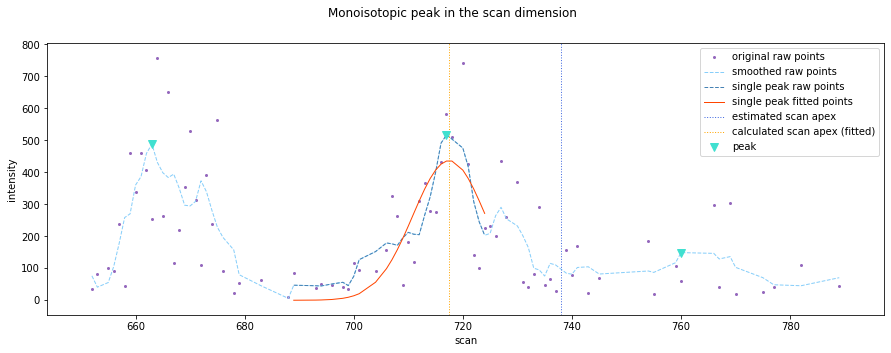

In [51]:
f, ax = plt.subplots()
# plot the original raw data
ax.plot(scan_0_df.scan, scan_0_df.intensity, marker='o', color='tab:purple', linestyle='', linewidth=2, ms=2, label='original raw points')
# plot the filtered intensity values
ax.plot(scan_0_df.scan, scan_0_metrics['original_intensity_filtered'], marker='', color='lightskyblue', linestyle='--', linewidth=1, ms=5, label='smoothed raw points')
if scan_0_metrics['number_of_peaks'] > 0:
    # plot the original filtered data constrained to a single peak
    ax.plot(scan_0_metrics['fitted_curve_df'].scan, scan_0_metrics['fitted_curve_df'].filtered_intensity, marker='', color='steelblue', linestyle='--', linewidth=1, ms=5, label='single peak raw points')
    # plot the fitted curve
    ax.plot(scan_0_metrics['fitted_curve_df'].scan, scan_0_metrics['fitted_curve_df'].fitted_intensity, marker='', color='orangered', linestyle='-', linewidth=1, ms=5, label='single peak fitted points')
# show the estimated apex
plt.axvline(x=estimated_scan_apex, linestyle=':', color='royalblue', linewidth=1, label='estimated scan apex')
# show the calculated apex
plt.axvline(x=scan_0_metrics['apex'], linestyle=':', color='orange', linewidth=1, label='calculated scan apex (fitted)')
# show the peaks if there's more than one
if scan_0_metrics['number_of_peaks'] > 1:
    peak_idxs = scan_0_metrics['peak_maxima_indexes']
    ax.plot(scan_0_df.scan.iloc[peak_idxs], scan_0_metrics['original_intensity_filtered'][peak_idxs], marker='v', color='turquoise', linestyle='', markeredgewidth=1, ms=8, label='peak')
plt.xlabel('scan')
plt.ylabel('intensity')
plt.legend(loc='best')
f.set_figheight(5)
f.set_figwidth(15)
plt.suptitle('Monoisotopic peak in the scan dimension')
plt.margins(0.06)
plt.show()

#### Isotope 1 peak

In [52]:
isotope_1_raw_points_df = isotope_raw_points_l[1]

Collapse the points onto the RT dimension

In [53]:
rt_1_df = isotope_1_raw_points_df.groupby(['frame_id','retention_time_secs'], as_index=False).intensity.sum()
rt_1_df.sort_values(by=['retention_time_secs'], ascending=True, inplace=True)
rt_1_df['x'] = rt_1_df.retention_time_secs
rt_1_metrics = fit_curve_to_flattened_isotope(rt_1_df, estimated_rt_apex, RT_WIDTH)

there are 8 peaks


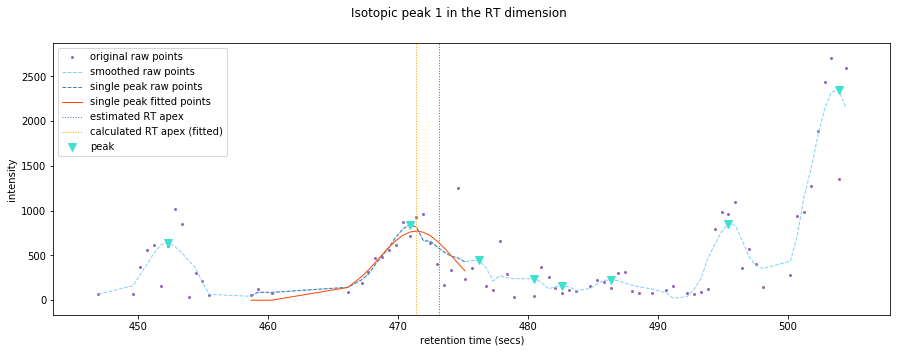

In [54]:
f, ax = plt.subplots()
# plot the original raw data
ax.plot(rt_1_df.retention_time_secs, rt_1_df.intensity, marker='o', color='tab:purple', linestyle='', linewidth=2, ms=2, label='original raw points')
# plot the filtered intensity values
ax.plot(rt_1_df.retention_time_secs, rt_1_metrics['original_intensity_filtered'], marker='', color='lightskyblue', linestyle='--', linewidth=1, ms=5, label='smoothed raw points')
if rt_1_metrics['number_of_peaks'] > 0:
    # plot the original filtered data constrained to a single peak
    ax.plot(rt_1_metrics['fitted_curve_df'].retention_time_secs, rt_1_metrics['fitted_curve_df'].filtered_intensity, marker='', color='steelblue', linestyle='--', linewidth=1, ms=5, label='single peak raw points')
    # plot the fitted curve
    ax.plot(rt_1_metrics['fitted_curve_df'].retention_time_secs, rt_1_metrics['fitted_curve_df'].fitted_intensity, marker='', color='orangered', linestyle='-', linewidth=1, ms=5, label='single peak fitted points')
# show the estimated apex
plt.axvline(x=estimated_rt_apex, linestyle=':', color='royalblue', linewidth=1, label='estimated RT apex')
# show the calculated apex
plt.axvline(x=rt_1_metrics['apex'], linestyle=':', color='orange', linewidth=1, label='calculated RT apex (fitted)')
# show the peaks if there's more than one
if rt_1_metrics['number_of_peaks'] > 1:
    peak_idxs = rt_1_metrics['peak_maxima_indexes']
    ax.plot(rt_1_df.retention_time_secs.iloc[peak_idxs], rt_1_metrics['original_intensity_filtered'][peak_idxs], marker='v', color='turquoise', linestyle='', markeredgewidth=1, ms=8, label='peak')
plt.xlabel('retention time (secs)')
plt.ylabel('intensity')
plt.legend(loc='best')
f.set_figheight(5)
f.set_figwidth(15)
# plt.xlim((rt_0_metrics['base_lower'],rt_0_metrics['base_upper']))
plt.suptitle('Isotopic peak 1 in the RT dimension')
plt.margins(0.06)
plt.show()

Collapse the points onto the mobility dimension

In [55]:
rt_peak_fwhm_lower = rt_1_metrics['apex'] - rt_1_metrics['full_width_half_max']
rt_peak_fwhm_upper = rt_1_metrics['apex'] + rt_1_metrics['full_width_half_max']
isotope_1_raw_points_df = isotope_1_raw_points_df[(isotope_1_raw_points_df.retention_time_secs >= rt_peak_fwhm_lower) & (isotope_1_raw_points_df.retention_time_secs <= rt_peak_fwhm_upper)].copy()

In [56]:
scan_1_df = isotope_1_raw_points_df.groupby(['scan'], as_index=False).intensity.sum()
scan_1_df.sort_values(by=['scan'], ascending=True, inplace=True)
scan_1_df['x'] = scan_1_df.scan
scan_1_metrics = fit_curve_to_flattened_isotope(scan_1_df, estimated_scan_apex, SCAN_WIDTH)

there are 3 peaks


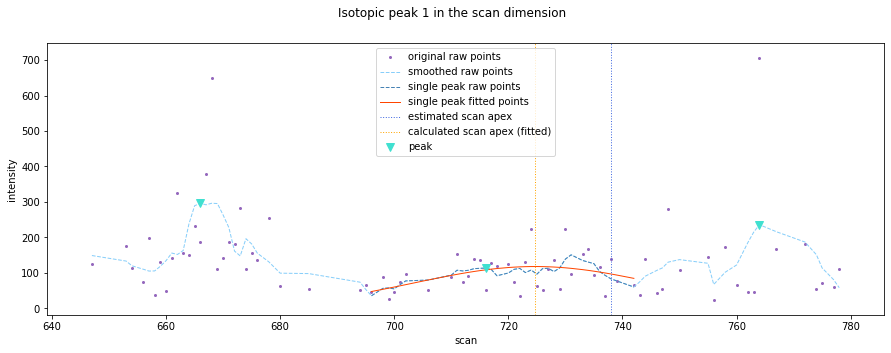

In [57]:
f, ax = plt.subplots()
# plot the original raw data
ax.plot(scan_1_df.scan, scan_1_df.intensity, marker='o', color='tab:purple', linestyle='', linewidth=2, ms=2, label='original raw points')
# plot the filtered intensity values
ax.plot(scan_1_df.scan, scan_1_metrics['original_intensity_filtered'], marker='', color='lightskyblue', linestyle='--', linewidth=1, ms=5, label='smoothed raw points')
if scan_1_metrics['number_of_peaks'] > 0:
    # plot the original filtered data constrained to a single peak
    ax.plot(scan_1_metrics['fitted_curve_df'].scan, scan_1_metrics['fitted_curve_df'].filtered_intensity, marker='', color='steelblue', linestyle='--', linewidth=1, ms=5, label='single peak raw points')
    # plot the fitted curve
    ax.plot(scan_1_metrics['fitted_curve_df'].scan, scan_1_metrics['fitted_curve_df'].fitted_intensity, marker='', color='orangered', linestyle='-', linewidth=1, ms=5, label='single peak fitted points')
# show the estimated apex
plt.axvline(x=estimated_scan_apex, linestyle=':', color='royalblue', linewidth=1, label='estimated scan apex')
# show the calculated apex
plt.axvline(x=scan_1_metrics['apex'], linestyle=':', color='orange', linewidth=1, label='calculated scan apex (fitted)')
# show the peaks if there's more than one
if scan_1_metrics['number_of_peaks'] > 1:
    peak_idxs = scan_1_metrics['peak_maxima_indexes']
    ax.plot(scan_1_df.scan.iloc[peak_idxs], scan_1_metrics['original_intensity_filtered'][peak_idxs], marker='v', color='turquoise', linestyle='', markeredgewidth=1, ms=8, label='peak')
plt.xlabel('scan')
plt.ylabel('intensity')
plt.legend(loc='best')
f.set_figheight(5)
f.set_figwidth(15)
plt.suptitle('Isotopic peak 1 in the scan dimension')
plt.margins(0.06)
plt.show()

#### Isotope 2 peak

In [58]:
isotope_2_raw_points_df = isotope_raw_points_l[2]

Collapse the points onto the RT dimension

In [59]:
rt_2_df = isotope_2_raw_points_df.groupby(['frame_id','retention_time_secs'], as_index=False).intensity.sum()
rt_2_df.sort_values(by=['retention_time_secs'], ascending=True, inplace=True)
rt_2_df['x'] = rt_2_df.retention_time_secs
rt_2_metrics = fit_curve_to_flattened_isotope(rt_2_df, estimated_rt_apex, RT_WIDTH)

there are 7 peaks


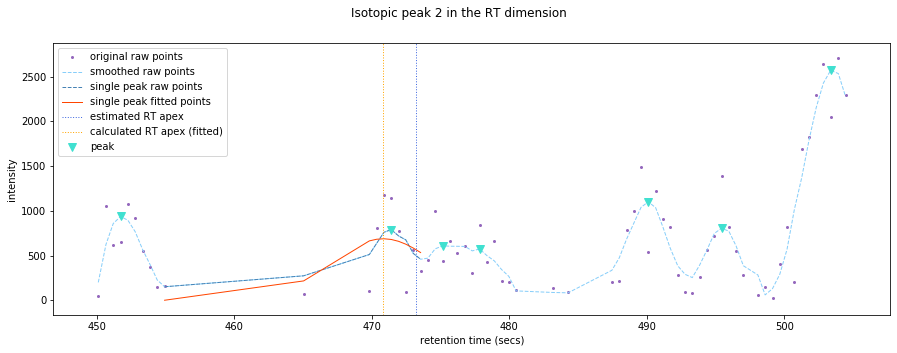

In [60]:
f, ax = plt.subplots()
# plot the original raw data
ax.plot(rt_2_df.retention_time_secs, rt_2_df.intensity, marker='o', color='tab:purple', linestyle='', linewidth=2, ms=2, label='original raw points')
# plot the filtered intensity values
ax.plot(rt_2_df.retention_time_secs, rt_2_metrics['original_intensity_filtered'], marker='', color='lightskyblue', linestyle='--', linewidth=1, ms=5, label='smoothed raw points')
if rt_2_metrics['number_of_peaks'] > 0:
    # plot the original filtered data constrained to a single peak
    ax.plot(rt_2_metrics['fitted_curve_df'].retention_time_secs, rt_2_metrics['fitted_curve_df'].filtered_intensity, marker='', color='steelblue', linestyle='--', linewidth=1, ms=5, label='single peak raw points')
    # plot the fitted curve
    ax.plot(rt_2_metrics['fitted_curve_df'].retention_time_secs, rt_2_metrics['fitted_curve_df'].fitted_intensity, marker='', color='orangered', linestyle='-', linewidth=1, ms=5, label='single peak fitted points')
# show the estimated apex
plt.axvline(x=estimated_rt_apex, linestyle=':', color='royalblue', linewidth=1, label='estimated RT apex')
# show the calculated apex
plt.axvline(x=rt_2_metrics['apex'], linestyle=':', color='orange', linewidth=1, label='calculated RT apex (fitted)')
# show the peaks if there's more than one
if rt_2_metrics['number_of_peaks'] > 1:
    peak_idxs = rt_2_metrics['peak_maxima_indexes']
    ax.plot(rt_2_df.retention_time_secs.iloc[peak_idxs], rt_2_metrics['original_intensity_filtered'][peak_idxs], marker='v', color='turquoise', linestyle='', markeredgewidth=1, ms=8, label='peak')
plt.xlabel('retention time (secs)')
plt.ylabel('intensity')
plt.legend(loc='best')
f.set_figheight(5)
f.set_figwidth(15)
# plt.xlim((rt_0_metrics['base_lower'],rt_0_metrics['base_upper']))
plt.suptitle('Isotopic peak 2 in the RT dimension')
plt.margins(0.06)
plt.show()

Collapse the points onto the mobility dimension

In [61]:
rt_peak_fwhm_lower = rt_2_metrics['apex'] - rt_2_metrics['full_width_half_max']
rt_peak_fwhm_upper = rt_2_metrics['apex'] + rt_2_metrics['full_width_half_max']
isotope_2_raw_points_df = isotope_2_raw_points_df[(isotope_2_raw_points_df.retention_time_secs >= rt_peak_fwhm_lower) & (isotope_2_raw_points_df.retention_time_secs <= rt_peak_fwhm_upper)].copy()

In [62]:
scan_2_df = isotope_2_raw_points_df.groupby(['scan'], as_index=False).intensity.sum()
scan_2_df.sort_values(by=['scan'], ascending=True, inplace=True)
scan_2_df['x'] = scan_2_df.scan
scan_2_metrics = fit_curve_to_flattened_isotope(scan_2_df, estimated_scan_apex, SCAN_WIDTH)

there are 3 peaks


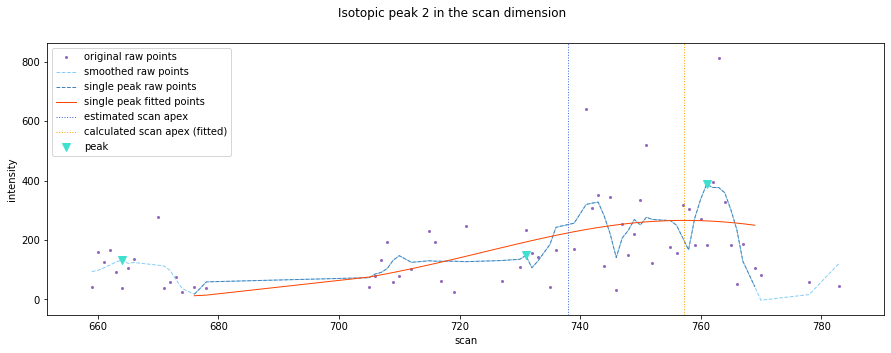

In [63]:
f, ax = plt.subplots()
# plot the original raw data
ax.plot(scan_2_df.scan, scan_2_df.intensity, marker='o', color='tab:purple', linestyle='', linewidth=2, ms=2, label='original raw points')
# plot the filtered intensity values
ax.plot(scan_2_df.scan, scan_2_metrics['original_intensity_filtered'], marker='', color='lightskyblue', linestyle='--', linewidth=1, ms=5, label='smoothed raw points')
# plot the original filtered data constrained to a single peak
ax.plot(scan_2_metrics['fitted_curve_df'].scan, scan_2_metrics['fitted_curve_df'].filtered_intensity, marker='', color='steelblue', linestyle='--', linewidth=1, ms=5, label='single peak raw points')
if scan_2_metrics['number_of_peaks'] > 0:
    # plot the fitted curve
    ax.plot(scan_2_metrics['fitted_curve_df'].scan, scan_2_metrics['fitted_curve_df'].fitted_intensity, marker='', color='orangered', linestyle='-', linewidth=1, ms=5, label='single peak fitted points')
    # show the estimated apex
    plt.axvline(x=estimated_scan_apex, linestyle=':', color='royalblue', linewidth=1, label='estimated scan apex')
# show the calculated apex
plt.axvline(x=scan_2_metrics['apex'], linestyle=':', color='orange', linewidth=1, label='calculated scan apex (fitted)')
# show the peaks if there's more than one
if scan_2_metrics['number_of_peaks'] > 1:
    peak_idxs = scan_2_metrics['peak_maxima_indexes']
    ax.plot(scan_2_df.scan.iloc[peak_idxs], scan_2_metrics['original_intensity_filtered'][peak_idxs], marker='v', color='turquoise', linestyle='', markeredgewidth=1, ms=8, label='peak')
plt.xlabel('scan')
plt.ylabel('intensity')
plt.legend(loc='best')
f.set_figheight(5)
f.set_figwidth(15)
plt.suptitle('Isotopic peak 2 in the scan dimension')
plt.margins(0.06)
plt.show()

#### Build a dictionary of the metrics

In [64]:
feature_metrics = {}

Calculate the feature metrics

In [65]:
calculated_monoisotopic_mz = isotope_peaks_df.iloc[0].mz_centroid
delta_mz_ppm = (calculated_monoisotopic_mz - estimated_monoisotopic_mz) / estimated_monoisotopic_mz * 1e6
feature_metrics['delta_mz_ppm'] = delta_mz_ppm

In [66]:
feature_metrics['delta_scan'] = (scan_0_metrics['apex'] - estimated_scan_apex) / estimated_scan_apex
feature_metrics['delta_rt'] = (rt_0_metrics['apex'] - estimated_rt_apex) / estimated_rt_apex

Calculate the delta ppm of the de-isotoped first and second isotopic peaks

In [67]:
# monoisotopic
monoisotopic_mz_centroid = isotope_peaks_df.iloc[0].mz_centroid

# first isotope
if isotope_peaks_df.iloc[1].summed_intensity > 0:
    isotope_1_mz_centroid = isotope_peaks_df.iloc[1].mz_centroid
else:
    isotope_1_mz_centroid = np.nan

# second isotope
if isotope_peaks_df.iloc[2].summed_intensity > 0:
    isotope_2_mz_centroid = isotope_peaks_df.iloc[2].mz_centroid
else:
    isotope_2_mz_centroid = np.nan

In [68]:
isotope_0_1_mz_delta_ppm = (monoisotopic_mz_centroid - (isotope_1_mz_centroid - (1 * expected_spacing_mz))) / monoisotopic_mz_centroid * 1e6
feature_metrics['isotope_0_1_mz_delta_ppm'] = isotope_0_1_mz_delta_ppm

In [69]:
isotope_0_2_mz_delta_ppm = (monoisotopic_mz_centroid - (isotope_2_mz_centroid - (2 * expected_spacing_mz))) / monoisotopic_mz_centroid * 1e6
feature_metrics['isotope_0_2_mz_delta_ppm'] = isotope_0_2_mz_delta_ppm

In [90]:
# isotope_1_raw_points_df = isotope_raw_points_l[1]
# isotope_2_raw_points_df = isotope_raw_points_l[2]

Calculate the RT apex deltas from the monoisotopic peak for the first and second isotopes

In [71]:
isotope_0_1_rt_delta = (rt_1_metrics['apex'] - rt_0_metrics['apex']) / rt_0_metrics['apex']
isotope_0_2_rt_delta = (rt_2_metrics['apex'] - rt_0_metrics['apex']) / rt_0_metrics['apex']
feature_metrics['isotope_0_1_rt_delta'] = isotope_0_1_rt_delta
feature_metrics['isotope_0_2_rt_delta'] = isotope_0_2_rt_delta

Calculate the scan apex deltas from the monoisotopic peak for the first and second isotopes

In [72]:
isotope_0_1_scan_delta = (scan_1_metrics['apex'] - scan_0_metrics['apex']) / scan_0_metrics['apex']
isotope_0_2_scan_delta = (scan_2_metrics['apex'] - scan_0_metrics['apex']) / scan_0_metrics['apex']
feature_metrics['isotope_0_1_scan_delta'] = isotope_0_1_scan_delta
feature_metrics['isotope_0_2_scan_delta'] = isotope_0_2_scan_delta

Calculate the monoisotopic peak intensity divided by the sum of the isotope peaks

In [73]:
monoisotope_int_over_isotope_peak_int_sum = isotope_peaks_df.iloc[0].summed_intensity / isotope_peaks_df.iloc[:3].summed_intensity.sum()
feature_metrics['monoisotope_int_over_isotope_peak_int_sum'] = monoisotope_int_over_isotope_peak_int_sum

Calculate the monoisotopic peak AUC divided by the sum of the isotope peak AUCs

In [74]:
monoisotope_auc_over_isotope_peak_auc_sum = rt_0_metrics['area_under_curve'] / (rt_0_metrics['area_under_curve'] + rt_1_metrics['area_under_curve'] + rt_2_metrics['area_under_curve'])
feature_metrics['monoisotope_auc_over_isotope_peak_auc_sum'] = monoisotope_auc_over_isotope_peak_auc_sum

Calculate the r-squared value for isotope peaks 1:0, 2:1 compared to the theoretical model

In [75]:
MAX_NUMBER_OF_SULPHUR_ATOMS = 3
MAX_NUMBER_OF_PREDICTED_RATIOS = 6

S0_r = np.empty(MAX_NUMBER_OF_PREDICTED_RATIOS+1, dtype=np.ndarray)
S0_r[1] = np.array([-0.00142320578040, 0.53158267080224, 0.00572776591574, -0.00040226083326, -0.00007968737684])
S0_r[2] = np.array([0.06258138406507, 0.24252967352808, 0.01729736525102, -0.00427641490976, 0.00038011211412])
S0_r[3] = np.array([0.03092092306220, 0.22353930450345, -0.02630395501009, 0.00728183023772, -0.00073155573939])
S0_r[4] = np.array([-0.02490747037406, 0.26363266501679, -0.07330346656184, 0.01876886839392, -0.00176688757979])
S0_r[5] = np.array([-0.19423148776489, 0.45952477474223, -0.18163820209523, 0.04173579115885, -0.00355426505742])
S0_r[6] = np.array([0.04574408690798, -0.05092121193598, 0.13874539944789, -0.04344815868749, 0.00449747222180])

S1_r = np.empty(MAX_NUMBER_OF_PREDICTED_RATIOS+1, dtype=np.ndarray)
S1_r[1] = np.array([-0.01040584267474, 0.53121149663696, 0.00576913817747, -0.00039325152252, -0.00007954180489])
S1_r[2] = np.array([0.37339166598255, -0.15814640001919, 0.24085046064819, -0.06068695741919, 0.00563606634601])
S1_r[3] = np.array([0.06969331604484, 0.28154425636993, -0.08121643989151, 0.02372741957255, -0.00238998426027])
S1_r[4] = np.array([0.04462649178239, 0.23204790123388, -0.06083969521863, 0.01564282892512, -0.00145145206815])
S1_r[5] = np.array([-0.20727547407753, 0.53536509500863, -0.22521649838170, 0.05180965157326, -0.00439750995163])
S1_r[6] = np.array([0.27169670700251, -0.37192045082925, 0.31939855191976, -0.08668833166842, 0.00822975581940])

S2_r = np.empty(MAX_NUMBER_OF_PREDICTED_RATIOS+1, dtype=np.ndarray)
S2_r[1] = np.array([-0.01937823810470, 0.53084210514216, 0.00580573751882, -0.00038281138203, -0.00007958217070])
S2_r[2] = np.array([0.68496829280011, -0.54558176102022, 0.44926662609767, -0.11154849560657, 0.01023294598884])
S2_r[3] = np.array([0.04215807391059, 0.40434195078925, -0.15884974959493, 0.04319968814535, -0.00413693825139])
S2_r[4] = np.array([0.14015578207913, 0.14407679007180, -0.01310480312503, 0.00362292256563, -0.00034189078786])
S2_r[5] = np.array([-0.02549241716294, 0.32153542852101, -0.11409513283836, 0.02617210469576, -0.00221816103608])
S2_r[6] = np.array([-0.14490868030324, 0.33629928307361, -0.08223564735018, 0.01023410734015, -0.00027717589598])

model_params = np.empty(MAX_NUMBER_OF_SULPHUR_ATOMS, dtype=np.ndarray)
model_params[0] = S0_r
model_params[1] = S1_r
model_params[2] = S2_r

# Find the ratio of H(peak_number)/H(peak_number-1) for peak_number=1..6
# peak_number = 0 refers to the monoisotopic peak
# number_of_sulphur = number of sulphur atoms in the molecule
def peak_ratio(monoisotopic_mass, peak_number, number_of_sulphur):
    ratio = None
    if (((1 <= peak_number <= 3) & (((number_of_sulphur == 0) & (498 <= monoisotopic_mass <= 3915)) |
                                    ((number_of_sulphur == 1) & (530 <= monoisotopic_mass <= 3947)) |
                                    ((number_of_sulphur == 2) & (562 <= monoisotopic_mass <= 3978)))) |
       ((peak_number == 4) & (((number_of_sulphur == 0) & (907 <= monoisotopic_mass <= 3915)) |
                              ((number_of_sulphur == 1) & (939 <= monoisotopic_mass <= 3947)) |
                              ((number_of_sulphur == 2) & (971 <= monoisotopic_mass <= 3978)))) |
       ((peak_number == 5) & (((number_of_sulphur == 0) & (1219 <= monoisotopic_mass <= 3915)) |
                              ((number_of_sulphur == 1) & (1251 <= monoisotopic_mass <= 3947)) |
                              ((number_of_sulphur == 2) & (1283 <= monoisotopic_mass <= 3978)))) |
       ((peak_number == 6) & (((number_of_sulphur == 0) & (1559 <= monoisotopic_mass <= 3915)) |
                              ((number_of_sulphur == 1) & (1591 <= monoisotopic_mass <= 3947)) |
                              ((number_of_sulphur == 2) & (1623 <= monoisotopic_mass <= 3978))))):
        beta0 = model_params[number_of_sulphur][peak_number][0]
        beta1 = model_params[number_of_sulphur][peak_number][1]
        beta2 = model_params[number_of_sulphur][peak_number][2]
        beta3 = model_params[number_of_sulphur][peak_number][3]
        beta4 = model_params[number_of_sulphur][peak_number][4]
        scaled_m = monoisotopic_mass / 1000.0
        ratio = beta0 + (beta1*scaled_m) + beta2*(scaled_m**2) + beta3*(scaled_m**3) + beta4*(scaled_m**4)
    return ratio

In [76]:
# calculate the theoretical and observed isotopic peak height ratios
monoisotopic_mass = calculate_monoisotopic_mass_from_mz(monoisotopic_mz_centroid, sequence_charge)
ratios = []
for isotope in range(1,4):
    expected_ratio = peak_ratio(monoisotopic_mass=monoisotopic_mass, peak_number=isotope, number_of_sulphur=0)
    observed_ratio = isotope_peaks_df.iloc[isotope].summed_intensity / isotope_peaks_df.iloc[isotope-1].summed_intensity
    ratios.append((expected_ratio, observed_ratio))

ratios_a = np.array(ratios)
r_squared_phr = calculate_r_squared(ratios_a[:,0], ratios_a[:,1])
feature_metrics['r_squared_phr'] = r_squared_phr

Calculate the geometric mean of the isotope peak intensities

In [77]:
geometric_mean_0_1 = np.log(isotope_peaks_df.iloc[0].summed_intensity * isotope_peaks_df.iloc[1].summed_intensity) / 2
geometric_mean_0_1_2 = np.log(isotope_peaks_df.iloc[0].summed_intensity * isotope_peaks_df.iloc[1].summed_intensity * isotope_peaks_df.iloc[2].summed_intensity) / 3
feature_metrics['geometric_mean_0_1'] = geometric_mean_0_1
feature_metrics['geometric_mean_0_1_2'] = geometric_mean_0_1_2

Calculate the m/z ppm standard deviation for isotopes 0 and 1

In [78]:
mz_centroid_0 = isotope_peaks_df.iloc[0].mz_centroid
mono_raw_points_df['mz_ppm_delta'] = (mono_raw_points_df.mz - mz_centroid_0) / mz_centroid_0 * 1e6
mz_delta_ppm_std_dev_0 = np.std(mono_raw_points_df.mz_ppm_delta)

In [79]:
mz_centroid_1 = isotope_peaks_df.iloc[1].mz_centroid
isotope_1_raw_points_df['mz_ppm_delta'] = (isotope_1_raw_points_df.mz - mz_centroid_1) / mz_centroid_1 * 1e6
mz_delta_ppm_std_dev_1 = np.std(isotope_1_raw_points_df.mz_ppm_delta)

/Users/darylwilding-mcbride/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [80]:
feature_metrics['mz_delta_ppm_std_dev_0'] = mz_delta_ppm_std_dev_0
feature_metrics['mz_delta_ppm_std_dev_1'] = mz_delta_ppm_std_dev_1

Calculate the symmetry of the isotopes in RT and CCS

In [81]:
feature_metrics['rt_peak_symmetry_0'] = rt_0_metrics['peak_symmetry']
feature_metrics['rt_peak_symmetry_1'] = rt_1_metrics['peak_symmetry']
feature_metrics['rt_peak_symmetry_2'] = rt_2_metrics['peak_symmetry']

feature_metrics['scan_peak_symmetry_0'] = scan_0_metrics['peak_symmetry']
feature_metrics['scan_peak_symmetry_1'] = scan_1_metrics['peak_symmetry']
feature_metrics['scan_peak_symmetry_2'] = scan_2_metrics['peak_symmetry']

Calculate the isotopic peak correlation with each other in RT

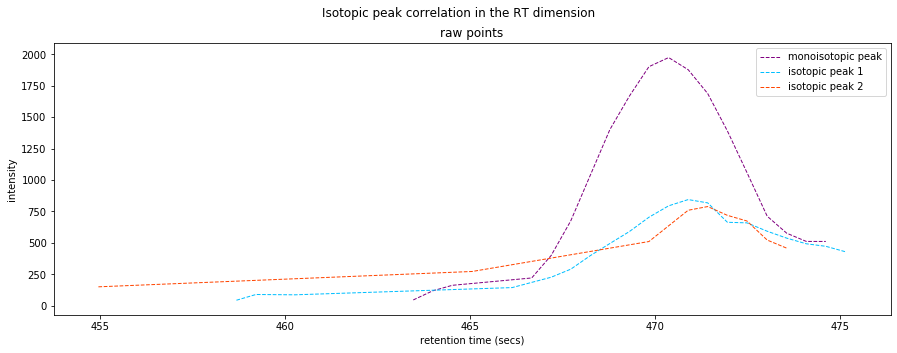

In [82]:
f, ax = plt.subplots()
ax.plot(rt_0_metrics['isolated_peak_df'].retention_time_secs, rt_0_metrics['isolated_peak_df'].filtered_intensity, marker='', color='purple', linestyle='--', linewidth=1, ms=2, label='monoisotopic peak')
ax.plot(rt_1_metrics['isolated_peak_df'].retention_time_secs, rt_1_metrics['isolated_peak_df'].filtered_intensity, marker='', color='deepskyblue', linestyle='--', linewidth=1, ms=2, label='isotopic peak 1')
ax.plot(rt_2_metrics['isolated_peak_df'].retention_time_secs, rt_2_metrics['isolated_peak_df'].filtered_intensity, marker='', color='orangered', linestyle='--', linewidth=1, ms=2, label='isotopic peak 2')
plt.xlabel('retention time (secs)')
plt.ylabel('intensity')
plt.legend(loc='best')
f.set_figheight(5)
f.set_figwidth(15)
plt.suptitle('Isotopic peak correlation in the RT dimension')
plt.title('raw points')
plt.margins(0.06)
plt.show()

In [83]:
rt_isolated_peak_0_df = rt_0_metrics['isolated_peak_df'][['frame_id','intensity']]
rt_isolated_peak_1_df = rt_1_metrics['isolated_peak_df'][['frame_id','intensity']]
rt_isolated_peak_2_df = rt_2_metrics['isolated_peak_df'][['frame_id','intensity']]

rt_combined_df = pd.merge(rt_isolated_peak_0_df, rt_isolated_peak_1_df, on='frame_id', how='left', suffixes=('_0', '_1')).sort_values(by='frame_id')
rt_combined_df = pd.merge(rt_combined_df, rt_isolated_peak_2_df, on='frame_id', how='left', suffixes=('_0', '_2')).sort_values(by='frame_id')
rt_combined_df.rename(columns={'intensity': 'intensity_2'}, inplace=True)
rt_combined_df.fillna(0, inplace=True)
rt_isotope_correlation = np.corrcoef(rt_combined_df[['intensity_0','intensity_1','intensity_2']].values, rowvar=False)[1,0]
feature_metrics['rt_isotope_correlation'] = rt_isotope_correlation


In [84]:
scan_isolated_peak_0_df = scan_0_metrics['isolated_peak_df'][['scan','intensity']]
scan_isolated_peak_1_df = scan_1_metrics['isolated_peak_df'][['scan','intensity']]
scan_isolated_peak_2_df = scan_2_metrics['isolated_peak_df'][['scan','intensity']]

scan_combined_df = pd.merge(scan_isolated_peak_0_df, scan_isolated_peak_1_df, on='scan', how='left', suffixes=('_0', '_1')).sort_values(by='scan')
scan_combined_df = pd.merge(scan_combined_df, scan_isolated_peak_2_df, on='scan', how='left', suffixes=('_0', '_2')).sort_values(by='scan')
scan_combined_df.rename(columns={'intensity': 'intensity_2'}, inplace=True)
scan_combined_df.fillna(0, inplace=True)
scan_isotope_correlation = np.corrcoef(scan_combined_df[['intensity_0','intensity_1','intensity_2']].values, rowvar=False)[1,0]
feature_metrics['scan_isotope_correlation'] = scan_isotope_correlation


Calculate the FWHM and peak base width of the monoisotopic peak in RT and CCS dimensions

In [85]:
feature_metrics['fwhm_rt_0'] = rt_0_metrics['full_width_half_max']
feature_metrics['peak_base_width_rt_0'] = rt_0_metrics['base_width']

feature_metrics['fwhm_scan_0'] = scan_0_metrics['full_width_half_max']
feature_metrics['peak_base_width_scan_0'] = scan_0_metrics['base_width']

Calculate the number of points and missing points in consecutive frames

In [86]:
rt_lower_0 = rt_0_metrics['isolated_peak_df'].retention_time_secs.min()
rt_upper_0 = rt_0_metrics['isolated_peak_df'].retention_time_secs.max()
ms1_frame_ids_0 = get_ms1_frame_ids(CONVERTED_DATABASE_NAME, rt_lower_0, rt_upper_0)
ms1_frame_ids_0_df = pd.DataFrame(ms1_frame_ids_0, columns=['frame_id'])
ms1_frame_ids_0_df['intensity'] = 0
merged_df = pd.merge(ms1_frame_ids_0_df, rt_isolated_peak_0_df, on='frame_id', how='left', suffixes=('_0', '_1')).sort_values(by='frame_id')
number_of_missing_frames_0 = merged_df.intensity_1.isna().sum()
feature_metrics['number_of_missing_frames_0'] = number_of_missing_frames_0
feature_metrics['number_of_frames_0'] = len(ms1_frame_ids_0_df)

In [87]:
rt_lower_1 = rt_1_metrics['isolated_peak_df'].retention_time_secs.min()
rt_upper_1 = rt_1_metrics['isolated_peak_df'].retention_time_secs.max()
ms1_frame_ids_1 = get_ms1_frame_ids(CONVERTED_DATABASE_NAME, rt_lower_1, rt_upper_1)
ms1_frame_ids_1_df = pd.DataFrame(ms1_frame_ids_1, columns=['frame_id'])
ms1_frame_ids_1_df['intensity'] = 0
merged_df = pd.merge(ms1_frame_ids_1_df, rt_isolated_peak_1_df, on='frame_id', how='left', suffixes=('_0', '_1')).sort_values(by='frame_id')
number_of_missing_frames_1 = merged_df.intensity_1.isna().sum()
feature_metrics['number_of_missing_frames_1'] = number_of_missing_frames_1
feature_metrics['number_of_frames_1'] = len(ms1_frame_ids_1_df)

In [88]:
rt_lower_2 = rt_2_metrics['isolated_peak_df'].retention_time_secs.min()
rt_upper_2 = rt_2_metrics['isolated_peak_df'].retention_time_secs.max()
ms1_frame_ids_2 = get_ms1_frame_ids(CONVERTED_DATABASE_NAME, rt_lower_2, rt_upper_2)
ms1_frame_ids_2_df = pd.DataFrame(ms1_frame_ids_2, columns=['frame_id'])
ms1_frame_ids_2_df['intensity'] = 0
merged_df = pd.merge(ms1_frame_ids_2_df, rt_isolated_peak_2_df, on='frame_id', how='left', suffixes=('_0', '_1')).sort_values(by='frame_id')
number_of_missing_frames_2 = merged_df.intensity_1.isna().sum()
feature_metrics['number_of_missing_frames_2'] = number_of_missing_frames_2
feature_metrics['number_of_frames_2'] = len(ms1_frame_ids_2_df)

In [89]:
feature_metrics

{'delta_mz_ppm': 0.7950062788232797,
 'delta_scan': -0.02776286083672613,
 'delta_rt': -0.0057963112163919705,
 'isotope_0_1_mz_delta_ppm': 0.28737361897403213,
 'isotope_0_2_mz_delta_ppm': 0.011127524096432459,
 'isotope_0_1_rt_delta': 0.0020319207272510567,
 'isotope_0_2_rt_delta': 0.000842348179531363,
 'isotope_0_1_scan_delta': 0.009985809877298744,
 'isotope_0_2_scan_delta': 0.05547789536832765,
 'monoisotope_int_over_isotope_peak_int_sum': 0.34178526803401094,
 'monoisotope_auc_over_isotope_peak_auc_sum': 0.5481815314261431,
 'r_squared_phr': -21.49451383588369,
 'geometric_mean_0_1': 10.65011596839236,
 'geometric_mean_0_1_2': 10.68390332231207,
 'mz_delta_ppm_std_dev_0': 3.1840100366697994,
 'mz_delta_ppm_std_dev_1': 3.1713513641774207,
 'rt_peak_symmetry_0': 1.3457658614281922,
 'rt_peak_symmetry_1': 0.9300303336703741,
 'rt_peak_symmetry_2': 0.2826568265682657,
 'scan_peak_symmetry_0': 1.8379133674895203,
 'scan_peak_symmetry_1': 1.2667509481668773,
 'scan_peak_symmetry_2': 2